In [66]:
!python -V

Python 3.9.12


In [113]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

In [68]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet') # leemos de parquet
# diccionario d datos https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
#gree_taxi_jan = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
#green_taxi_feb = pd.read_parquet('./data/green_tripdata_2021-02.parquet')

In [69]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) # parseamos el string a datetime
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [70]:
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime # calculamos la duración del viaje
# duracion del viaje = hora de bajada - hora de abordaje
df["duration"] 

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Name: duration, Length: 76518, dtype: timedelta64[ns]

Este formato de salida no es util para el modelo, asi que lo vamos a convertir a la duracion en minutos

In [71]:
td = df.duration.copy().iloc[0]
td.total_seconds()/60 # el primer viaje tardó 4 minutos
# aplicamos el mismo tratamiento a toda la columna

3.933333333333333

In [72]:
df["duration"] = df.duration.apply(lambda x: x.total_seconds()/60) # aplicando a toda la columna
# de la columna duracion nos interesa conocer la distribucion de esta variable

In [73]:

df = df[(df.duration >= 1) & (df.duration <=60)]

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

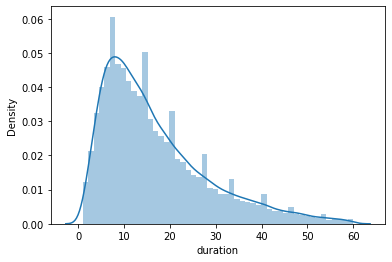

In [74]:
sns.distplot(df.duration)

In [78]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [81]:
df [categorical]= df[categorical].astype(str)

In [87]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

In [88]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [89]:
X_train # esto crea la matrix de features que utilizaremos para entrenar el modelo

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [96]:
# dv.feature_names_
# para ver el los features que utilizaremos

In [99]:
target = "duration"
y_train = df[target].values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [100]:
# Entrenando una regresión lineal
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
# no tenemos datset de validacion, utilizaremos el mes de febrero como dataset de validación

In [101]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


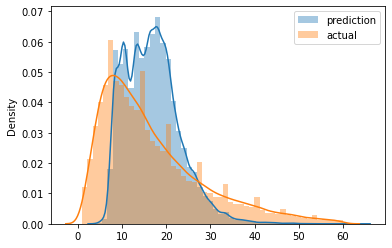

In [112]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.legend()
plt.show()

In [115]:
# calcular el performance en el datset de entrenamiento
mean_squared_error(y_train, y_pred, squared=False) # squared=False para obtener root_mean_squared_error

9.775464278878395

El modelo se equivoca en la predicción en promedio en 9 minutos.

rmse_lasso 133.68101098510675


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

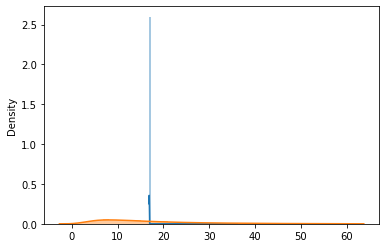

In [120]:
# usando un Lasso Regression
from sklearn.linear_model import Lasso
lasso_lr = Lasso()
lasso_lr.fit(X_train, y_train)
y_pred_lasso = lasso_lr.predict(X_train)
print("rmse_lasso", mean_squared_error(y_train, y_pred_lasso))
sns.distplot(y_pred_lasso,label="lasso_prediction")
sns.distplot(y_train,label="actual")

## No queremos estar repitiendo la ejecución de este proceso celda por celda
---

Vamos a crear funciones para este proceso

In [126]:
# los más de los duros, los reales, los meros buenos
import pandas as pd
import numpy as np

# para graficar
import matplotlib.pyplot as plt
import seaborn as sns   

# libreria que usaremos para aprendizaje
import sklearn

# para preprocesamiento
from sklearn.feature_extraction import DictVectorizer

# los modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# las metricas
from sklearn.metrics import mean_squared_error

In [193]:
# la funcion para leer los datos
def leer_dataframe(filename):

    df = pd.read_parquet(filename)

    # parseamos el string a datetime
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df.duration.apply(lambda x: x.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <=60)]

    # convirtiendo la duracion a segundos
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df
    

In [194]:
df_train = leer_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = leer_dataframe('./data/green_tripdata_2021-02.parquet')
print(df_train.shape, df_val.shape)

(73908, 21) (61921, 21)


In [195]:
print(df_train.PULocationID.nunique())
print(df_train.DOLocationID.nunique())

250
256


In [196]:
print(df_val.PULocationID.nunique())
print(df_val.DOLocationID.nunique())

245
254


In [197]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [202]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts) # OJO aqui solo usamos transform

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [203]:
print(X_train.shape, y_train.shape)

(73908, 507) (73908,)


In [204]:
print(X_val.shape, y_val.shape)

(61921, 507) (61921,)


10.473871054242926


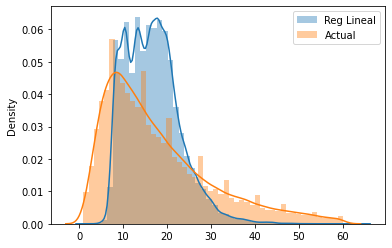

In [213]:
# entrenando Regresion Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

y_pred_rl = rl.predict(X_val)

print(mean_squared_error(y_val, y_pred_rl, squared=False))
sns.distplot(y_pred_rl, label='Reg Lineal')
sns.distplot(y_val, label='Actual')
plt.legend();

12.212583224318818


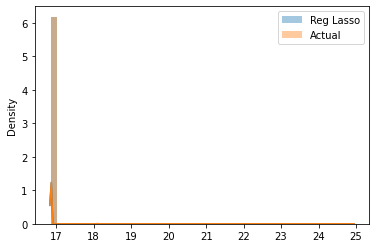

In [214]:
# entrenando Regresion Lineal
rl_lasso = Lasso()
rl_lasso.fit(X_train, y_train)

y_pred_lasso = rl_lasso.predict(X_val)

print(mean_squared_error(y_val, y_pred_lasso, squared=False))
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_pred_lasso, label='Actual')
plt.legend();

## Creando un nuevo feature
---

In [223]:
# creando un nuevo feature
df_train["PU_LO"] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val["PU_LO"] = df_val.PULocationID + '_' + df_val.DOLocationID

In [224]:
categorical = ["PU_LO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts) # OJO aqui solo usamos transform

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


7.4793657829373155


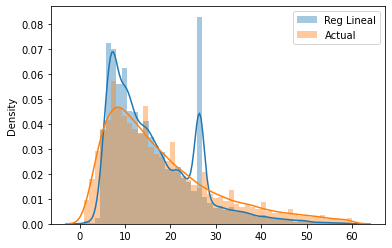

In [225]:
# entrenando Regresion Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

y_pred_rl = rl.predict(X_val)

print(mean_squared_error(y_val, y_pred_rl, squared=False))
sns.distplot(y_pred_rl, label='Reg Lineal')
sns.distplot(y_val, label='Actual')
plt.legend();

In [226]:
import pickle
with open("models/lin_reg.bin", "wb") as f:
    pickle.dump((dv,lr), f)

9.233436225720547


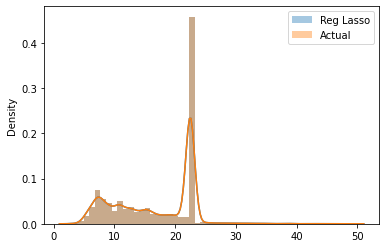

In [227]:
# entrenando Regresion Lineal
rl_lasso = Lasso(0.001)
rl_lasso.fit(X_train, y_train)

y_pred_lasso = rl_lasso.predict(X_val)

print(mean_squared_error(y_val, y_pred_lasso, squared=False))
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_pred_lasso, label='Actual')
plt.legend();